In [41]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import firebase_admin

from firebase_admin import credentials
from firebase_admin import firestore
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
# dataset_url = "gs://image-cat/images"
dataset_url =  "https://github.com/Kota-Quest/KotaQuest.github.io/blob/main/images.tar.gz?raw=true"
data_dir = tf.keras.utils.get_file('./images.tar.gz', origin=dataset_url, untar=True)
data_dir = pathlib.Path('./.keras/datasets/images/')

18620416/18618452 [==============================] - 1s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1246


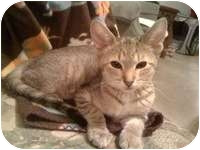

In [5]:
abyssinian = list(data_dir.glob('Abyssinian/*'))
PIL.Image.open(str(abyssinian[0]))

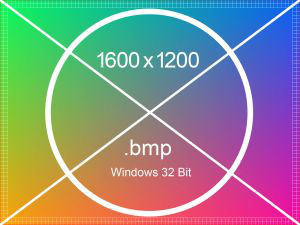

In [6]:
PIL.Image.open(str(abyssinian[1]))

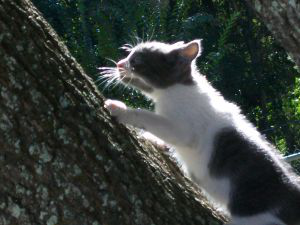

In [7]:
americanbobtail = list(data_dir.glob('American Bobtail/*'))
PIL.Image.open(str(americanbobtail[0]))

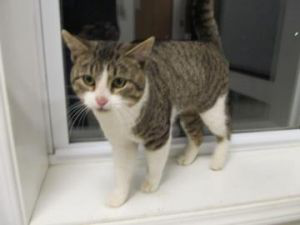

In [8]:
PIL.Image.open(str(americanbobtail[1]))

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1246 files belonging to 2 classes.
Using 997 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1246 files belonging to 2 classes.
Using 249 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['Abyssinian', 'American Bobtail']


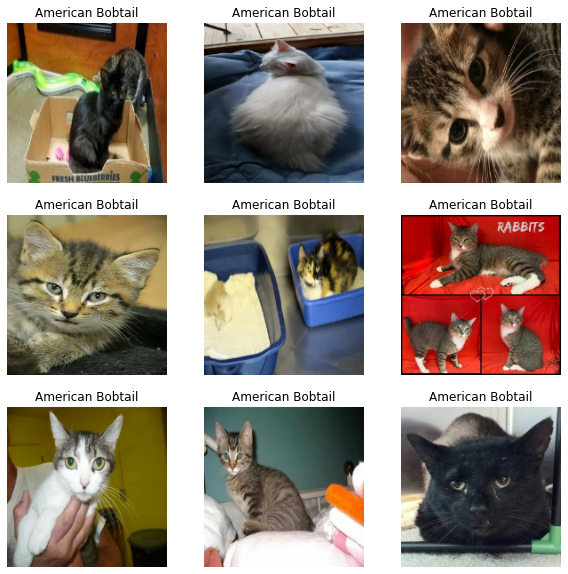

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [19]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
32/32 [==============================] - 15s 478ms/step - loss: 0.6068 - accuracy: 0.7773 - val_loss: 0.4904 - val_accuracy: 0.8153
Epoch 2/10
32/32 [==============================] - 14s 453ms/step - loss: 0.4840 - accuracy: 0.7924 - val_loss: 0.4780 - val_accuracy: 0.8153
Epoch 3/10
32/32 [==============================] - 15s 454ms/step - loss: 0.4413 - accuracy: 0.8205 - val_loss: 0.4688 - val_accuracy: 0.8193
Epoch 4/10
32/32 [==============================] - 14s 452ms/step - loss: 0.3972 - accuracy: 0.8205 - val_loss: 0.5126 - val_accuracy: 0.7791
Epoch 5/10
32/32 [==============================] - 15s 453ms/step - loss: 0.3140 - accuracy: 0.8676 - val_loss: 0.5371 - val_accuracy: 0.7470
Epoch 6/10
32/32 [==============================] - 15s 467ms/step - loss: 0.2744 - accuracy: 0.8947 - val_loss: 0.6338 - val_accuracy: 0.8313
Epoch 7/10
32/32 [==============================] - 15s 456ms/step - loss: 0.2324 - accuracy: 0.9057 - val_loss: 0.7096 - val_accuracy: 0.6667

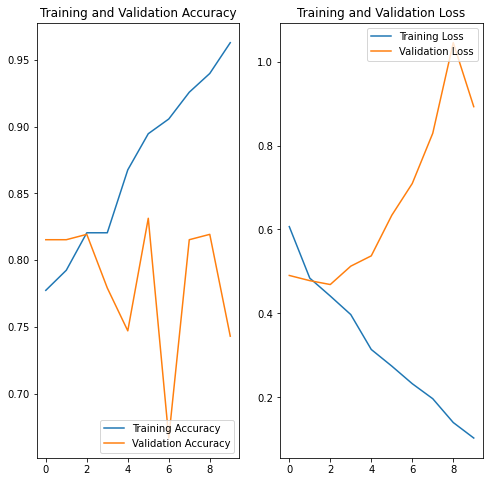

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

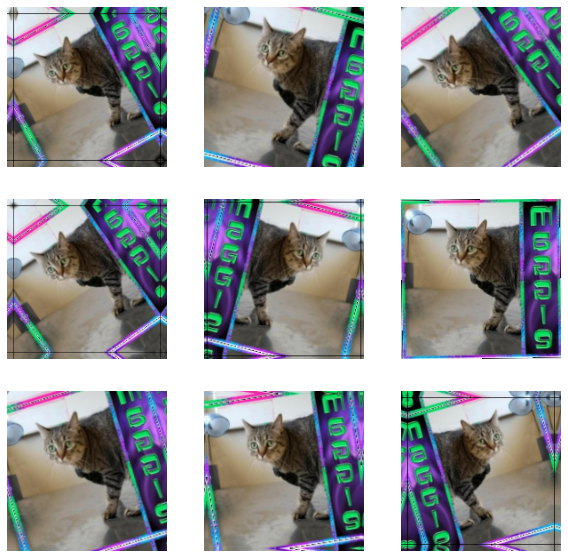

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [26]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [29]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
32/32 [==============================] - 23s 725ms/step - loss: 0.5957 - accuracy: 0.7733 - val_loss: 0.5225 - val_accuracy: 0.8153
Epoch 2/15
32/32 [==============================] - 23s 717ms/step - loss: 0.5126 - accuracy: 0.7904 - val_loss: 0.4728 - val_accuracy: 0.8153
Epoch 3/15
32/32 [==============================] - 23s 715ms/step - loss: 0.4950 - accuracy: 0.7924 - val_loss: 0.4706 - val_accuracy: 0.8153
Epoch 4/15
32/32 [==============================] - 24s 736ms/step - loss: 0.4824 - accuracy: 0.7874 - val_loss: 0.4567 - val_accuracy: 0.8153
Epoch 5/15
32/32 [==============================] - 23s 719ms/step - loss: 0.4922 - accuracy: 0.7854 - val_loss: 0.4602 - val_accuracy: 0.8153
Epoch 6/15
32/32 [==============================] - 23s 722ms/step - loss: 0.4779 - accuracy: 0.7894 - val_loss: 0.4724 - val_accuracy: 0.8032
Epoch 7/15
32/32 [==============================] - 23s 734ms/step - loss: 0.4772 - accuracy: 0.7844 - val_loss: 0.4637 - val_accuracy: 0.8032

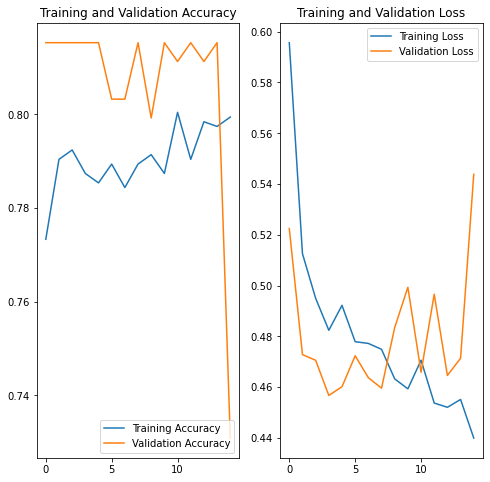

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [58]:
if not firebase_admin._apps:
    cred = credentials.Certificate('/home/jupyter/kota-quest-2831b6d300f4.json')
    firebase_admin.initialize_app(cred)

db = firestore.client()  # this connects to our Firestore database
# collection = db.collection('quests')  # opens 'places' collection

In [78]:
# docs = db.collection(u'quests').stream()

# for doc in docs:
#     print(f'{doc.id} => {doc.to_dict()}')
quests = db.collection('quests')

# Create a query against the collection
query_ref = quests.where('name', '==', 'alex')
print(query_ref)

In [79]:
cat_url = "https://firebasestorage.googleapis.com/v0/b/kota-quest.appspot.com/o/images%2F44927473_101.jpg?alt=media&token=4836b1f7-cc0c-4551-a08c-84123e338acc"
cat_path = tf.keras.utils.get_file('./images/44927473_101', origin=cat_url)

img = keras.preprocessing.image.load_img(
    cat_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Abyssinian with a 90.67 percent confidence.
